# Predicting market recession using macroeconomic data

The Data Collection and Metadata notebook can be found as Part_1 : https://www.kaggle.com/devarshraval/1-data-collection-for-predicting-recession

In [1]:
import pandas as pd
df=pd.read_csv("../input/us-macroeconomic-data-19962020-source-fred/macrodata.csv",index_col=0,parse_dates=True)
df

,RPI,INDPRO,CE16OV,UNRATE,PAYEMS,USGOOD,USTPU,HOUST,PERMIT,DPCERA3M086SBEA,...,EXUSUK,WPSFD49207,WPSID61,CPIAUCSL,SP500,NASDAQ,GOLDBAR,Regime,P/E,Dividend Yield
1996-01-01,8909.327,74.6841,125125.0,5.6,118316.0,23196.0,23947.0,1467.0,1387.0,63.691,...,1.5288,129.7,125.5,154.700,636.020020,1059.790039,20.754421,Normal,18.6845,2.26
1996-02-01,8983.863,75.8344,125639.0,5.5,118739.0,23280.0,23988.0,1491.0,1420.0,64.180,...,1.5360,129.7,125.0,155.000,640.429993,1100.050049,21.372637,Normal,18.8140,2.16
1996-03-01,9015.588,75.7631,125862.0,5.5,118993.0,23276.0,24030.0,1424.0,1437.0,64.491,...,1.5271,130.5,125.3,155.500,645.500000,1101.400024,21.460953,Normal,18.9630,2.18
1996-04-01,9039.466,76.4562,125994.0,5.6,119158.0,23316.0,24043.0,1516.0,1463.0,64.729,...,1.5160,130.9,125.7,156.100,654.169983,1190.520020,21.637589,Normal,18.7388,2.19
1996-05-01,9078.928,77.0161,126244.0,5.6,119486.0,23358.0,24137.0,1504.0,1457.0,64.813,...,1.5152,130.9,126.2,156.400,669.119995,1243.430054,22.255806,Normal,19.1670,2.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,17219.643,109.2966,158759.0,3.5,152463.0,21205.0,27830.0,1567.0,1438.0,121.765,...,1.2953,206.0,195.2,259.050,2954.219971,8567.370117,18.868309,Normal,25.3952,1.97
2020-03-01,16947.234,104.5221,155772.0,4.4,151090.0,21086.0,27723.0,1269.0,1356.0,113.894,...,1.2369,202.4,192.2,257.953,2584.590088,7700.100098,18.215258,Recession,22.2177,2.25
2020-04-01,19124.430,91.2658,133403.0,14.7,130303.0,18698.0,24475.0,934.0,1066.0,99.932,...,1.2420,196.3,185.3,255.902,2912.429932,8889.549805,25.572948,Recession,25.0359,2.41
2020-05-01,18296.406,92.0613,137242.0,13.3,133028.0,19374.0,24858.0,1038.0,1216.0,108.449,...,1.2302,200.4,185.3,255.768,3044.310059,9489.870117,23.862782,Recession,26.1696,2.10


In [2]:
import numpy as np
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller #to check unit root in time series 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import seaborn as sns #for correlation heatmap

import warnings
warnings.filterwarnings('ignore')

### Data preprocessing

1) Add lags of the variables as additional features

2) Test stationarity of time series

3) Standardize the dataset

In [3]:
df.index.set_names(names='Date',inplace=True)

In [4]:
# add lags
for col in df.drop(['Regime'], axis=1):
    for n in [3,6,9,12,18]:
        df['{} {}M lag'.format(col, n)] = df[col].shift(n).ffill().values

# 1 month ahead prediction
df["Regime"]=df["Regime"].shift(-1)

In [5]:
df=df.dropna(axis=0)

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time . It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The mean and variance do not change over time. 
[towardsdatascience.com,Stationarity in time series analysis | by Shay Palachy]

In [6]:
# Check stationarity in time series data
# We will perform adfuller test to check unit roots 3 times. 
# First time for non-stationary series we will take first order difference
# Second time we will take second order difference
# Third time if there are still remaining non-stationary columns we will drop them from feature set

from statsmodels.tsa.stattools import adfuller #to check unit root in time series 
threshold=0.01 #significance level
for column in df.drop(['Regime'], axis=1):
    result=adfuller(df[column])
    if result[1]>threshold:
        df[column]=df[column].diff()
df1=df.dropna(axis=0)

for column in df1.drop(['Regime'], axis=1):
    result=adfuller(df1[column])
    if result[1]>threshold:
        df1[column]=df1[column].diff()
df1=df1.dropna(axis=0)

nonstationary_col=[]
for column in df1.drop(['Regime'], axis=1):
    result=adfuller(df1[column])
    if result[1]>threshold:
        nonstationary_col.append(column)
df1=df1.dropna(axis=0)
df1.drop(nonstationary_col,axis=1,inplace=True)

In [7]:
nonstationary_col

['M1SL', 'M2SL', 'BUSLOANS']

In [8]:
from sklearn.preprocessing import StandardScaler
features=df1.drop(['Regime'],axis=1)
col_names=features.columns

scaler=StandardScaler()
scaler.fit(features)
standardized_features=scaler.transform(features)

df2=pd.DataFrame(data=standardized_features,columns=col_names,index=df1.index)
df2.insert(loc=1,column='Regime', value=df1['Regime'].values)
df2.shape

(272, 256)

In [9]:
df2

,RPI,Regime,INDPRO,CE16OV,UNRATE,PAYEMS,USGOOD,USTPU,HOUST,PERMIT,...,P/E 3M lag,P/E 6M lag,P/E 9M lag,P/E 12M lag,P/E 18M lag,Dividend Yield 3M lag,Dividend Yield 6M lag,Dividend Yield 9M lag,Dividend Yield 12M lag,Dividend Yield 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1997-09-01,-0.019222,Normal,-0.092885,-0.012275,0.105684,0.351575,-0.203158,1.044795,1.612323,0.722492,...,0.133200,-0.126677,-0.064161,0.145419,0.021145,-1.121120,0.248294,-0.121566,-0.236551,0.257931
1997-10-01,0.111637,Normal,-0.012774,0.093111,-0.355484,0.237336,0.045756,-0.460404,-0.253244,0.092274,...,0.244321,0.139850,0.060054,-0.133070,-0.034617,-1.121120,0.991809,-0.616936,-0.855224,0.133539
1997-11-01,0.220409,Normal,0.016372,0.312259,-0.201761,0.208004,-0.000651,-0.040033,-0.089239,-0.459167,...,-0.203835,0.171354,0.015940,0.198375,0.062862,0.116982,-1.982251,-0.864622,-1.102693,-0.488422
1997-12-01,0.161187,Normal,-0.368241,-0.000411,0.105684,0.214179,0.045756,-0.087494,0.587286,-0.191324,...,0.173120,0.134218,-0.126469,-0.064026,0.005352,-0.130638,-1.114817,0.249962,-0.112817,-0.115246
1998-01-01,0.333314,Normal,0.135777,0.014246,-0.201761,0.174813,0.016224,-0.023083,-0.407000,1.573286,...,-0.044600,0.245447,0.140065,0.060183,-0.215364,-0.254448,-1.114817,0.993017,-0.607755,1.253069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.592724,Normal,-0.062443,-0.080672,0.105684,0.136990,0.024662,-0.087494,0.320776,1.258177,...,-0.096236,0.099770,0.101195,0.175938,-0.090079,0.116982,-0.743059,-0.740779,-0.112817,-0.115246
2020-02-01,0.493636,Recession,0.442948,0.012850,-0.201761,0.165550,0.172323,-0.090884,-0.499253,-1.530538,...,0.108158,-0.062174,-0.215354,0.088132,0.096540,-0.749689,0.991809,0.621489,-1.226428,-0.239638
2020-03-01,-1.839730,Recession,-3.728129,-2.103250,1.335468,-1.087997,-0.747393,-0.362091,-3.041345,-1.278451,...,0.093593,0.054941,0.208140,0.054253,0.013166,-0.502069,-0.495221,-0.121566,-0.236551,-0.239638


In [10]:
# import packages for modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from matplotlib import pyplot as mp
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [11]:
Label = df2["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df2.insert(loc=2, column="Label", value=Label.values)

#### Train Test Split
Assigning 75% of data as training set and 30 % as test set

In [12]:
df_targets=df2['Label'].values
df_features=df2.drop(['Regime','Label'], axis=1)

df_training_features = df2[:'2014-09'].drop(['Regime','Label'], axis=1)
df_validation_features = df2['2014-10':].drop(['Regime','Label'], axis=1)

df_training_targets = df2[:'2014-09']['Label'].values


df_validation_targets = df2['2014-10':]['Label'].values

In [13]:
xtr=df_training_features[:'2006-03']
ytr=df2[:'2006-03']['Label'].values
xdev=df_training_features['2006-04':]
ydev=df2['2006-04':'2014-09']['Label'].values

In [14]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

204 204 272
68 68 272


## Modelling

As the dataset is too small and recessions are in continuous in time series, we cannot use cross validation functions as folds with only one class will be formed.

Thus, loop and iteration of hyperparamets is done in hypertuning Logistic Regression.

In [15]:
df_training_targets

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

LR: 0.889647 (0.012917)
LR_L1: 0.782196 (0.136043)
LR_L2: 0.964248 (0.020658)
LDA: 0.864393 (0.038752)
KNN: 0.680769 (0.019231)
GB: 0.909095 (0.055007)
ABC: 0.842719 (0.152153)
RF: 0.984857 (0.010015)
XGB: 0.985535 (0.014465)


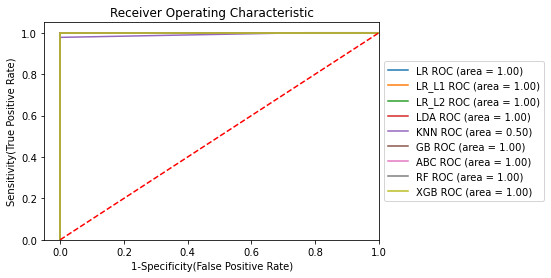

In [16]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=2) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1',solver='liblinear')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

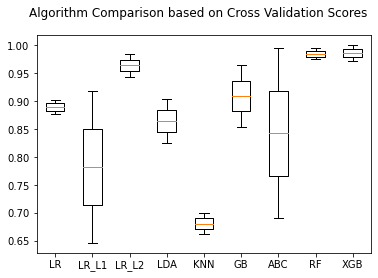

In [17]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Thus, it is clear Logistic Regression with L2 norm and XGboost perform best in cross validation.

### Hypertuning Logistic Regression 

In [18]:
from sklearn.metrics import roc_auc_score
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])
penalty=['l1','l2']

penals=pd.DataFrame(index=penalty)
cs=[]
scrs=[]
for p in penalty:
        scores=[]
        params=pd.DataFrame(index=C)
        for c in C:
            model=LogisticRegression(C=c,max_iter=10000,penalty=p,solver='liblinear')
            lr1=model.fit(xtr,ytr)
            ypreds=lr1.predict(xdev)
            score=roc_auc_score(ydev,ypreds)
            scores.append(score)
        params['rocauc']=scores
        maxc=params['rocauc'].idxmax()
        maxsc=params['rocauc'].max()
        scrs.append(maxsc)
        cs.append(maxc)
penals['C']=cs
penals['score']=scrs
penals

,C,score
l1,1000.0,0.748016
l2,1000.0,0.750000


In [19]:
model=LogisticRegression(C=1000,penalty='l2',max_iter=10000,solver='liblinear')
lr1=model.fit(df_training_features,df_training_targets)
ypreds=lr1.predict(df_validation_features)
param=lr1.get_params()
score=roc_auc_score(df_validation_targets,ypreds)
score

0.8125

#### XGBoost model

In [20]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=2) 
lb = preprocessing.LabelBinarizer()
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree'],
                                                  'max_depth':[2,3,5,10],
                                                  'learning_rate':[0.01,0.1,1]},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
modelxg=xgb.XGBClassifier(learning_rate=0.001,n_estimators=1000,max_depth=100,booster='gbtree',n_jobs=-1).fit(df_training_features, df_training_targets)
ypredsxgb=modelxg.predict(df_validation_features)

xgbscore=roc_auc_score(df_validation_targets,ypredsxgb)
xgbscore

0.75

Thus, it is clear XGboost model overfits on train data and LG(l2) model performs better on test data.

## Results

In [22]:
import datetime
# define periods of recession
rec_spans = []

rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,10,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,5,1)])
rec_spans.append([datetime.datetime(2020,3,1), datetime.datetime(2020,5,1)])

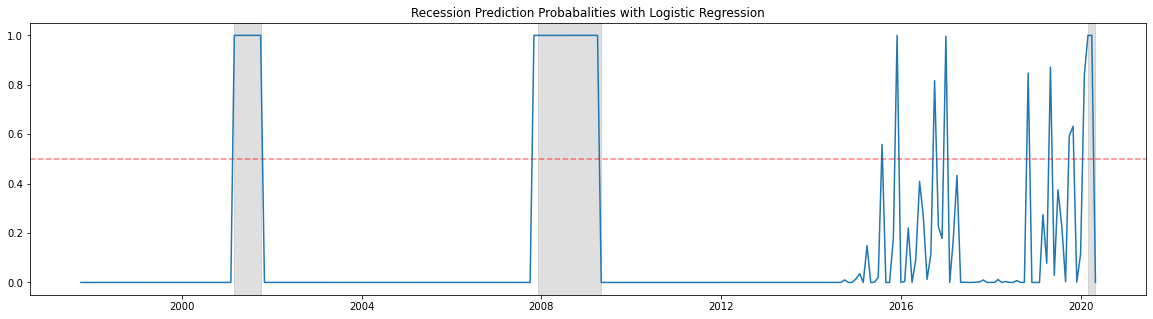

In [23]:
prob_predictions = lr1.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, lr1.predict_proba(df_validation_features), axis=0)
sample_range = pd.date_range(start='10/1/1997', end='5/1/2020', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
plt.show()

Thus, the blue line graph past 2014 is the predicted probabilities of our model. One can see it does not predict recession for continuous two months until 2020 when the actual recession started. 
Limitation of this model is the period range of data selected is shorter, as in the online course data was selected for 1960-2018. 
Thus, with more sophistication this model can be used to predict market recession in one month prior.

### Feature Importance
Feature importance is obtained using the shap library. The results are somewhat intuitive with the Nasdaq lag feature, US exchange rate, federal funds rate and AAA bonnd rate being prominent features that influence the model results.

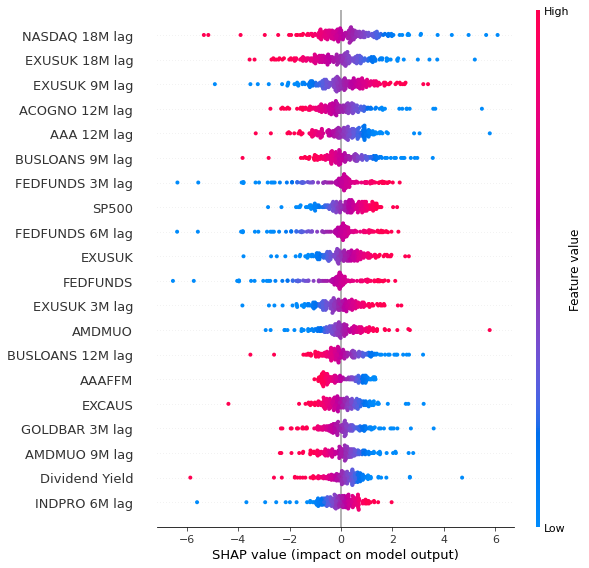

In [24]:
import shap
# load your data here, e.g. X and y
# create and fit your model here
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(lr1,df_training_features)
shap_values = explainer.shap_values(df_training_features.values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.summary_plot(shap_values, df_training_features)

## Limitations and Future Scope
Some limitations for this model are described and can be regarded as future scope/tasks for Kaggle and GitHub users:

#### 1. Range of time periods:

The shorter time period was selected for two main reasons:

To consider more number of features such as exchange rates(EXUSUK,etc), Consumer goods demand(ACOGNO) and business inventories(BUSINV), data for which is not available in past.

In addition, it is discussed in the online course that recent data holds more importance to predict future trends.

However, user can experiment with time period to obtain a optimal range with minimal noise.

#### 2. Modern potential indicators are not used such as 
(a)cryptocurrency rates, 

(b)news sentiment analysis,

(c)Research and innovation indices(especially important going forward owing to public health and climate crisis)

(d)Political and geopolitical stability indices